## Importando as bibliotecas necessárias

In [1]:
import pickle
from PIL import Image
from mtcnn import MTCNN
from tensorflow import keras
import cv2 as cv
from skimage.io import imread, imshow
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Carregando os modelos

In [2]:
facenet_model = keras.models.load_model('./facenet_keras.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [3]:
facenet_model.summary()

_________________
Block8_1_Branch_1_Conv2d_0b_1x3 (None, 3, 3, 192)    0           Block8_1_Branch_1_Conv2d_0b_1x3_B
__________________________________________________________________________________________________
Block8_1_Branch_0_Conv2d_1x1 (C (None, 3, 3, 192)    344064      Mixed_7a[0][0]                   
__________________________________________________________________________________________________
Block8_1_Branch_1_Conv2d_0c_3x1 (None, 3, 3, 192)    110592      Block8_1_Branch_1_Conv2d_0b_1x3_A
__________________________________________________________________________________________________
Block8_1_Branch_0_Conv2d_1x1_Ba (None, 3, 3, 192)    576         Block8_1_Branch_0_Conv2d_1x1[0][0
__________________________________________________________________________________________________
Block8_1_Branch_1_Conv2d_0c_3x1 (None, 3, 3, 192)    576         Block8_1_Branch_1_Conv2d_0c_3x1[0
___________________________________________________________________________________________

In [4]:
mlp_model = pickle.load(open('./mlp_model.pkl', 'rb'))

In [5]:
detector = MTCNN()

## Definindo a descrição e a cor dos labels para serem usados na OpenCV

In [6]:
label_description = {
    0: 'NO MASK',
    1: 'MASK'
}

color = {
    0: (0, 0, 255),
    1: (0, 255, 0)
}

## Métodos

In [7]:
def get_faces(image, size=(160, 160)):

    '''
      Esta função é responsável por extrair as faces de uma imagem através do modelo MTCNN.
      Parâmetros:
        * image: uma imagem de qualquer dimensão;
        * size: refere-se ao shape de redimensionamento das faces, o padrão é (160, 160).
      Retorno: uma lista de imagens (faces) do tipo Image Pillow. Caso nenhuma face tenha sido detectada, o retorno é uma lista vazia.
    '''

    # Transformando imagem em um array numpy
    img = np.asarray(image)

    # Capturando as faces da imagem através da MTCNN
    results = detector.detect_faces(np.asarray(image))

    # Lista para armazenar as faces
    faces = []

    # Percorrendo a lista de faces detectadas
    for i in range(len(results)):
      
      try:

        # Caso a face tenha sido detectada com mais de 95% de certeza, essa condição é verdadeira
        if results[i]['confidence'] > 0.95:

          # Extraindo os pontos da face
          x1, y1, w, h = results[i]['box']
          x2, y2 = x1 + w, y1 + h

          # Extraindo a face da imagem fazendo slice nos pontos identificados pela MTCNN
          face = image[y1:y2, x1:x2]

          # Adicionando a face encontrada e suas informações na lista de faces
          faces.append({
              'x1': x1,
              'y1': y1,
              'x2': x2,
              'y2': y2,
              'face': np.array(Image.fromarray(face).resize(size)),
              'confidence': results[i]['confidence']
          })

      except:
        continue

    return faces

In [8]:
def get_embeddings(face, facenet_model):

  '''
    Esta função é responsável por receber uma imagem e fornecer os embeddings da mesma, através do modelo FaceNet.
    Parâmetros:
      * face: é uma imagem com dimensão 160x160, referente a uma face extraída de uma imagem;
      * facenet_model: é uma instância do modelo FaceNet previamente treinado, responsável por gerar os embeddings da imagem.
    Retorno: um array numpy com 128 posições, referentes às 128 características da FaceNet (embeddings).
  '''

  # Convertendo a imagem para numpy e normalizando para o intervalo [0..1]
  img = np.array(face).astype('float32')/255

  # Expandindo a dimensão da imagem para adequá-la à entrada da FaceNet
  # O shape deve ficar (1, 160, 160)
  input = np.expand_dims(img, axis=0)

  # Fazendo a predição do modelo para extrair os embeddings da imagem
  embedding = facenet_model.predict(input)[0]

  return embedding

In [9]:
def get_label(embedding, mlp_model):

    '''
        Esta função é responsável por realizar a predição do modelo de classificação a partir das características de entrada.
        Parâmetros:
            * embedding: vetor de características de uma face, representado por um array numpy com 128 valores;
            * mlp_model: modelo treinado do classificador MLP.
        Retorno: um variável label, que terá valor 0 (maskoff) ou 1 (maskon).
    '''

    # Expandindo dimensão do array para adequá-lo à entrada do classificador
    # A dimensão deve ficar (1, 128)
    embedding = np.expand_dims(embedding, axis=0)

    # Realizando a predição da probabilidade de acerto para cada classe
    proba = mlp_model.predict_proba(embedding)

    # Extraindo do vetor de probabilidades o label que apresentou o maior resultado
    label = np.argmax(proba)

    # Caso o modelo não tenha mais de 95% de certeza sobre o maior resultado, o label predito receberá o valor inverso
    # Por exemplo, se o modelo não tiver mais de 95% de certeza sobre classificar como label 1, o retorno será label 0
    if proba[0][label] < 0.95:
        label = abs(label-1)
    
    return label

In [10]:
def mark_points_in_frame(frame):

    '''
        Este método é responsável por receber um frame (imagem), detectar as faces existentes, classificá-las de acordo com o uso da máscara e marcar sua categorização visivelmente através da OpenCV.
        Parâmetro:
            * frame: uma imagem de qualquer dimensão, pode ser um frame de um vídeo.
        Retorno: uma imagem com marcações feitas através da OpenCV.
    '''

    # Transformando a imagem em array numpy
    img = np.asarray(frame)

    # Extraindo faces da imagem
    faces = get_faces(img)

    # Iniciando contador responsável por marcar quantas pessoas sem máscara existem na imagem
    no_mask_count = 0

    # Percorrendo a lista de faces identificadas
    for face in faces:

        # Extraindo os pontos da face
        x1 = face['x1']
        x2 = face['x2']
        y1 = face['y1']
        y2 = face['y2']

        # Extraindo os embeddings da face
        emb = get_embeddings(face['face'], facenet_model)

        # Classificando a face em label 0 (maskon) ou label 1 (maskoff)
        label = get_label(emb, mlp_model)

        # Caso uma pessoa sem máscara seja identificada, o contador é incrementado
        if not label: no_mask_count += 1

        # Configurando o tipo e o tamanho da fonte para iniciar as marcações na imagem
        font = cv.FONT_HERSHEY_TRIPLEX
        font_scale = 0.5

        # Desenhando um retângulo em torno da face
        img = cv.rectangle(img, (x1, y1), (x2, y2), color[label], 2)

        # Escrevendo a classificação MASK ou NO MASK em cima do retângulo desenhado
        # Essa descrição é baseada no label
        cv.putText(img, label_description[label], (x1, y1-10), font, fontScale=font_scale,
                    color=color[label], thickness=1)

        # Escrevendo no topo do frame um informativo sobre quantas pessoas estão sem máscara na imagem
        cv.putText(img, f'People without mask: {no_mask_count}', (15, 15), font, fontScale=0.6,
                    color=(0, 0, 0), thickness=1)

    return img

## Testando uma imagem

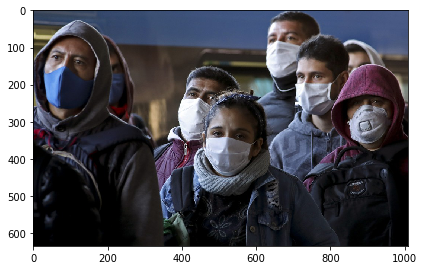

In [11]:
img_test = imread('./img_test.jpg')
imshow(img_test)

In [12]:
faces = get_faces(img_test)

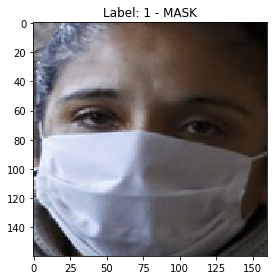

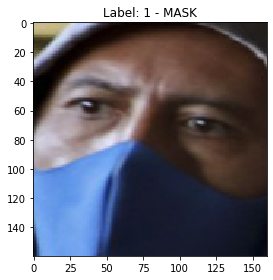

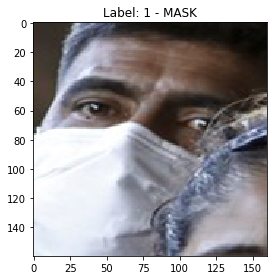

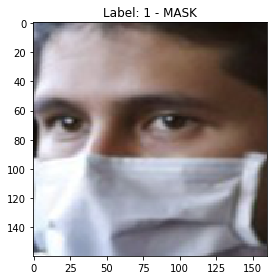

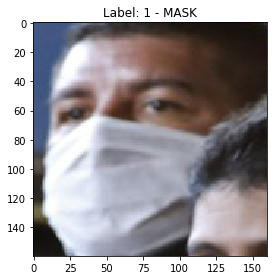

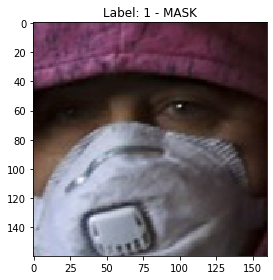

In [13]:
for i in range(len(faces)):
    emb = get_embeddings(faces[i]['face'], facenet_model)
    label = get_label(emb, mlp_model)
    conf = faces[i]['confidence']
    plt.figure()
    plt.title(f'Label: {label} - {label_description[label]}')
    imshow(faces[i]['face'])

## Detectando o uso de máscara em um vídeo

In [14]:
print('Iniciando captura...\n')

# Instanciando um objeto VideoCapture, para selecionar sua webcam
# Também é possível renderizar um vídeo pronto, basta você passar o caminho desse arquivo no lugar do parâmetro 0
vid = cv.VideoCapture(0)

print('Captura iniciada!')

# A captura dos frames através da sua webcam ou vídeo será feita até que você pressione a tecla 'q'
while (True):

    # Lendo a imagem e extraindo o frame
    # O método read() retorna dois resultados. O primeiro diz se a captura do frame foi feita com sucesso ou não, enquanto o segundo entrega o frame capturado.
    _, frame = vid.read()

    # Fazendo a detecção de máscara e as marcações nas faces identificadas no frame
    detec = mark_points_in_frame(frame)

    # Exibindo o frame resultante do método anterior
    cv.imshow('frame', detec)

    # Condição de parada do loop: pressione a tecla 'q'
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

# Fechando o arquivo de vídeo ou dispositivo de captura
vid.release()

# Fechando as janelas abertas
cv.destroyAllWindows()

# Apagando o objeto da memória
del (vid)

Iniciando captura...

Captura iniciada!
